In [3]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.xception import (
    Xception, preprocess_input, decode_predictions)
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.mixed_precision import Policy


In [4]:
# Set mixed precision policy
# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

In [6]:
#Set up directories
#import os
# Print the current working directory
print("Current working directory:", os.getcwd())

base_dir = "c:/Users/KatreeceHattaway/OneDrive - Sock Club/Desktop/UT_Data_Boot_Camp/ML_pneumonia_identification/Resources"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Check if directories exist
print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))
print("Test directory exists:", os.path.exists(test_dir))


Current working directory: c:\Users\KatreeceHattaway\OneDrive - Sock Club\Desktop\UT_Data_Boot_Camp\ML_pneumonia_identification\Resources
Train directory exists: True
Validation directory exists: True
Test directory exists: True


In [9]:
# Data Preprocessing
#reprocess and resize the images to be able to train and test the model with random transformations

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
val_test_datagen = ImageDataGenerator(rescale=1/255)

In [10]:
#reprocess and resize the images to be able to train and test the model
train = ImageDataGenerator(rescale = 1/255)
test = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)

In [12]:
target_size = (128, 128)  # Reduced image size

In [15]:
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,  # Increased batch size
    class_mode='binary',
    #workers=4  # Number of workers for data loading
)

val_data_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    #workers=4
)

test_data_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    #workers=4
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# Model Building
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is in float32 for compatibility
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Training
history = model.fit(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen
)

Epoch 1/5


c:\Users\KatreeceHattaway\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 703ms/step - accuracy: 0.8158 - loss: 0.5862 - val_accuracy: 0.8750 - val_loss: 0.3728
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 741ms/step - accuracy: 0.9079 - loss: 0.2196 - val_accuracy: 0.8750 - val_loss: 0.4105
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 739ms/step - accuracy: 0.9119 - loss: 0.2193 - val_accuracy: 0.8750 - val_loss: 0.3169
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 746ms/step - accuracy: 0.9181 - loss: 0.2050 - val_accuracy: 0.8750 - val_loss: 0.3824
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 746ms/step - accuracy: 0.9222 - loss: 0.1900 - val_accuracy: 0.7500 - val_loss: 0.6209


In [ ]:
# Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen
)

In [19]:
# Evaluation
test_loss, test_acc = model.evaluate(test_data_gen)
print(f"Test Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - accuracy: 0.8414 - loss: 0.3742
Test Accuracy: 0.85


In [20]:
# Predictions and Metrics
test_data_gen.reset()
y_pred = (model.predict(test_data_gen) > 0.5).astype("int32")
y_true = test_data_gen.classes

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 655ms/step
Precision: 0.90
Recall: 0.86
F1 Score: 0.88


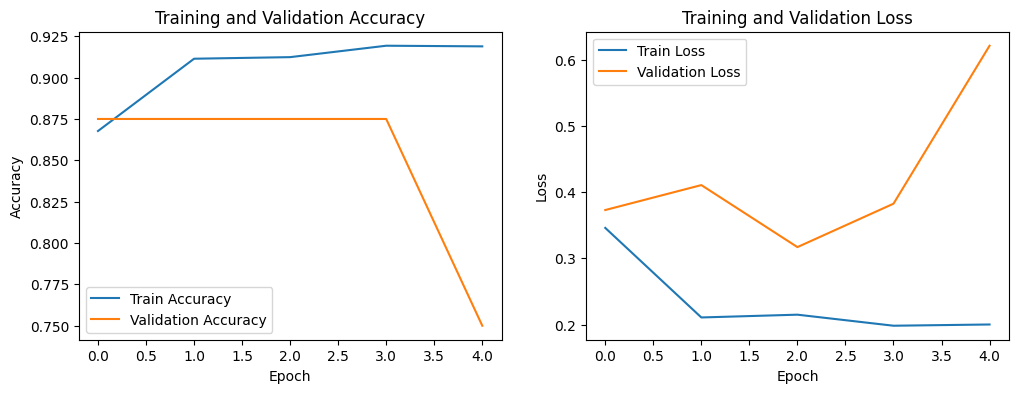

In [21]:
# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

Explain why recall is important for these purposes. Explain how this can be used
Set the stage
Explain our methodology
Each person explain their approach
Hones in on highest f1, accuracy and recall model and talk about that
